In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [2]:
BATCH_SIZE = 8
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=80

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "rice_leaf_diseases",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 120 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Bacterial leaf blight', 'Brown spot', 'Leaf smut']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(8, 256, 256, 3)
[0 1 1 0 2 0 1 2]


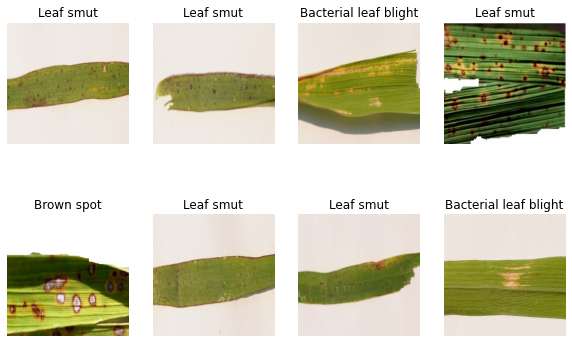

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(8):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
len(dataset)

15

In [8]:
train_size = 0.8
len(dataset)*train_size

12.0

In [9]:
train_ds = dataset.take(12)
len(train_ds)

12

In [10]:
test_ds = dataset.skip(12)
len(test_ds)

3

In [11]:
val_size=0.1
len(dataset)*val_size

1.5

In [12]:
val_ds = test_ds.take(1)
len(val_ds)

1

In [13]:
test_ds = test_ds.skip(1)
len(test_ds)

2

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)


12

In [17]:
len(val_ds)

1

In [18]:
len(test_ds)

2

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [21]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [22]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [23]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (8, 256, 256, 3)          0         
_________________________________________________________________
conv2d (Conv2D)              (8, 254, 254, 32)         896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (8, 127, 127, 32)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (8, 125, 125, 64)         18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (8, 62, 62, 64)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (8, 60, 60, 64)           36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (8, 30, 30, 64)          

In [25]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=80,
)

Epoch 1/80
12/12 [==============================] - 13s 797ms/step - loss: 1.1231 - accuracy: 0.2812 - val_loss: 1.0851 - val_accuracy: 0.3750
Epoch 2/80
12/12 [==============================] - 7s 592ms/step - loss: 1.0977 - accuracy: 0.3438 - val_loss: 1.0521 - val_accuracy: 0.3750
Epoch 3/80
12/12 [==============================] - 8s 616ms/step - loss: 1.0843 - accuracy: 0.4062 - val_loss: 0.9033 - val_accuracy: 0.6250
Epoch 4/80
12/12 [==============================] - 7s 552ms/step - loss: 1.0866 - accuracy: 0.3021 - val_loss: 0.9529 - val_accuracy: 0.3750
Epoch 5/80
12/12 [==============================] - 7s 584ms/step - loss: 1.0287 - accuracy: 0.4062 - val_loss: 0.7872 - val_accuracy: 0.6250
Epoch 6/80
12/12 [==============================] - 7s 553ms/step - loss: 1.0136 - accuracy: 0.3750 - val_loss: 1.0724 - val_accuracy: 0.6250
Epoch 7/80
12/12 [==============================] - 7s 540ms/step - loss: 1.0398 - accuracy: 0.4688 - val_loss: 0.8646 - val_accuracy: 0.3750
Epoch

12/12 [==============================] - 7s 537ms/step - loss: 0.4870 - accuracy: 0.8021 - val_loss: 0.5238 - val_accuracy: 0.7500
Epoch 59/80
12/12 [==============================] - 7s 533ms/step - loss: 0.4141 - accuracy: 0.8229 - val_loss: 0.3209 - val_accuracy: 0.8750
Epoch 60/80
12/12 [==============================] - 7s 552ms/step - loss: 0.4510 - accuracy: 0.8333 - val_loss: 0.1908 - val_accuracy: 0.8750
Epoch 61/80
12/12 [==============================] - 7s 551ms/step - loss: 0.5491 - accuracy: 0.7708 - val_loss: 0.2932 - val_accuracy: 0.8750
Epoch 62/80
12/12 [==============================] - 7s 564ms/step - loss: 0.4836 - accuracy: 0.7917 - val_loss: 0.4949 - val_accuracy: 0.7500
Epoch 63/80
12/12 [==============================] - 7s 589ms/step - loss: 0.4231 - accuracy: 0.8646 - val_loss: 0.2967 - val_accuracy: 0.7500
Epoch 64/80
12/12 [==============================] - 7s 541ms/step - loss: 0.4176 - accuracy: 0.8229 - val_loss: 0.3307 - val_accuracy: 0.7500
Epoch 65/80

In [27]:
scores = model.evaluate(test_ds)

2/2 [==============================] - 1s 137ms/step - loss: 0.2335 - accuracy: 0.9375


In [28]:
scores

[0.2334621250629425, 0.9375]

In [29]:
history

In [30]:
history.params

{'verbose': 1, 'epochs': 80, 'steps': 12}

In [31]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [32]:
type(history.history['loss'])

list

In [33]:
len(history.history['loss'])

80

In [34]:
history.history['loss'][:5]

[1.1231249570846558,
 1.097697377204895,
 1.0842723846435547,
 1.0866475105285645,
 1.0286616086959839]

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

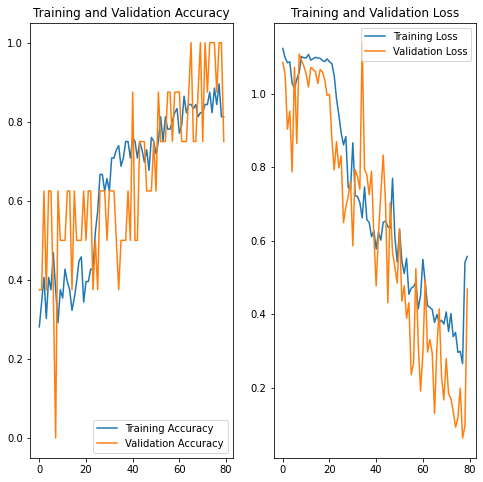

In [36]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Bacterial leaf blight
predicted label: Bacterial leaf blight


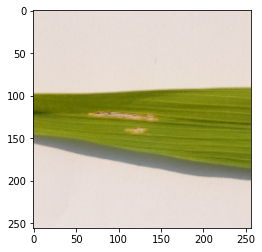

In [37]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [38]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

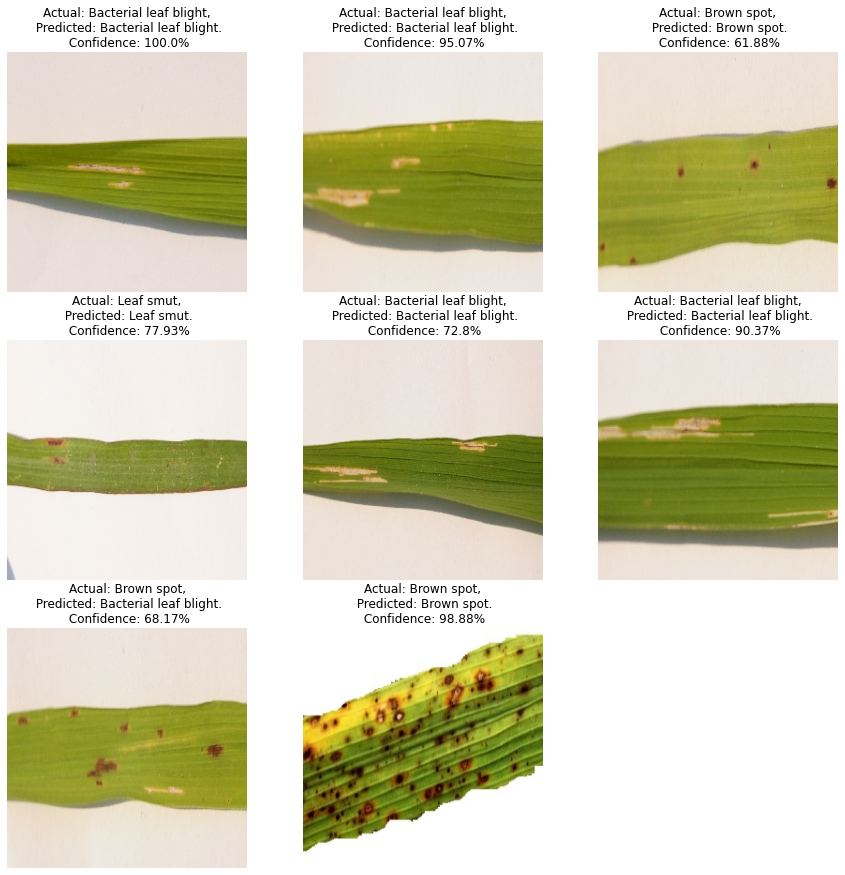

In [61]:
plt.figure(figsize=(15, 15))
predict_c=[]
actual_c=[]

for images, labels in test_ds.take(1):
    for i in range(8):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        predict_c.append(predicted_class)
        actual_class = class_names[labels[i]] 
        actual_c.append(actual_class)
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [62]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/12\assets


In [63]:
model.save("../rice3.h5")


In [64]:
import sklearn
from sklearn.metrics import classification_report, confusion_matrix

In [65]:
print(predict_c)


['Bacterial leaf blight', 'Bacterial leaf blight', 'Brown spot', 'Leaf smut', 'Bacterial leaf blight', 'Bacterial leaf blight', 'Bacterial leaf blight', 'Brown spot']


In [66]:
print(actual_c)

['Bacterial leaf blight', 'Bacterial leaf blight', 'Brown spot', 'Leaf smut', 'Bacterial leaf blight', 'Bacterial leaf blight', 'Brown spot', 'Brown spot']


In [67]:
confusion_matrix(actual_c, predict_c, labels=class_names)

array([[4, 0, 0],
       [1, 2, 0],
       [0, 0, 1]], dtype=int64)

In [68]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[4 0 0]
 [1 2 0]
 [0 0 1]]


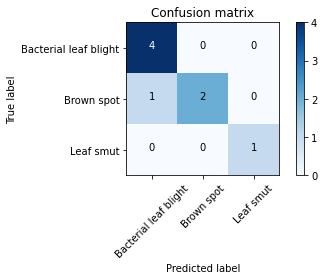

In [69]:
cnf_matrix = confusion_matrix(actual_c, predict_c, labels=class_names)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')

In [70]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(actual_c, predict_c)))

print('Micro Precision: {:.2f}'.format(precision_score(actual_c, predict_c, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(actual_c, predict_c, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(actual_c, predict_c, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(actual_c, predict_c, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(actual_c, predict_c, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(actual_c, predict_c, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(actual_c, predict_c, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(actual_c, predict_c, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(actual_c, predict_c, average='weighted')))


Accuracy: 0.88

Micro Precision: 0.88
Micro Recall: 0.88
Micro F1-score: 0.88

Macro Precision: 0.93
Macro Recall: 0.89
Macro F1-score: 0.90

Weighted Precision: 0.90
Weighted Recall: 0.88
Weighted F1-score: 0.87
